# Computation Intelligence for Optimization | Sports League Optimization
`Group AM`
- Eduardo Mendes, 20240850
- Helena Duarte, 20240530
- João Freire, 20240528
- Mariana Sousa, 20240516

<div class="alert alert-block alert-info">

# Table of Contents
    
[1. Import Libraries](#1)<br>

[2. Problem Definition](#2)<br>

[3. Data Preprocessing](#3)<br>

[4. Tests](#4)<br>

[5. Performance Evaluation](#5)<br>

<a class="anchor" id="1">

# 1. Import Libraries
    
</a>

In [ ]:
import sys
sys.path.append(".")

from Model.Solution import SportsLeagueSolution
from Operators.Selection import tournament_selection, ranking_selection
from Operators.Crossover import standard_crossover_with_position_repair, crossover_by_position_dual_any
from Operators.Mutation import player_swap_mutation, role_shuffle_mutation, player_role_left_shift_mutation
from Model.genetic_algorithm import SportsLeagueGASolution, genetic_algorithm

from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from itertools import combinations
from scipy.stats import levene
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

<a class="anchor" id="2">

# 2. Problem Definiton
    
</a>

In a fantasy sports league, the objective is to assign players to teams in a way that ensures
a balanced distribution of talent while staying within salary caps.

1) Each player is defined by the following attributes:
* Skill rating: Represents the player's ability.
* Cost: The player's salary.
* Position (One of four roles) : Goalkeeper (GK), Defender (DEF), Midfielder (MID), or Forward (FWD).

A solution is a complete league configuration, specifying the team assignment for each player. These are the constraints that must be verified in every solution of the search space (no object is considered a solution if it doesn’t comply with these):
* Each team must consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders and 2
Forwards.
* Each player is assigned to exactly one team.

*Impossible Configurations*: Teams that do not follow this exact structure (e.g., a team with 2 goalkeepers, or a team where the same defender is assigned twice) are not part of the search space and are not considered solutions. It is forbidden to generate such an arrangement during evolution.

Besides that, each team should not exceed a 750€ million total budget. If it does, it is not a valid solution and the fitness value should reflect that.

The `objective` is to create a balanced league that complies with the constraints. 
A balanced league a is a league where the average skill rating of the players is roughly the same among the teams. 
This can be measured by the standard deviation of the average skill rating of the teams.

You can find a dataset of players with their names, position, skill rating and salary (in million €).
These players should be distributed across 5 teams of 7 players each.

<a class="anchor" id="3">

# 3. Data Preprocessing
    
</a>

In order to use the code, some processing must be done to the dataset to re-name columns into more intuitive names and to order players by position

In [2]:
df = pd.read_csv("Data/players(in).csv", index_col=0)

# change the column names to lowercase
df.rename(columns={
    "Name": "name",
    "Position": "position",
    "Skill": "skill",
    "Salary (€M)": "salary"
}, inplace=True)

position_order = ["GK", "DEF", "MID", "FWD"] # the order of positions

# Create a mapping dictionary: {'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3}
df_sorted = df.sort_values(by="position", key=lambda x: x.map({pos: i for i, pos in enumerate(position_order)})).reset_index(drop=True)

# Create a column "id" in the sorted DataFrame
df_sorted["id"]= df_sorted.index

df_sorted.head(5)

,name,position,skill,salary,id
0,Alex Carter,GK,85,90,0
1,Jordan Smith,GK,88,100,1
2,Ryan Mitchell,GK,83,85,2
3,Chris Thompson,GK,80,80,3
4,Blake Henderson,GK,87,95,4


<a class="anchor" id="4">

# 4. Tests
    
</a>

Tests performed to ensure the developped code works

## SportsLeagueSolution tests

In [3]:
sol = SportsLeagueSolution(players_df=df_sorted)


In [4]:
sol.repr

[[0, 9, 5, 17, 21, 26, 27],
 [2, 8, 13, 20, 24, 29, 31],
 [3, 6, 14, 18, 22, 34, 30],
 [4, 12, 10, 19, 16, 25, 33],
 [1, 11, 7, 23, 15, 32, 28]]

In [5]:
sol.fitness()

1000000000.0

## Selector Tests

In [6]:
POP_SIZE = 50
initial_population = [
    SportsLeagueSolution(players_df=df_sorted)
    for _ in range(POP_SIZE)
]

In [7]:
selected = tournament_selection(initial_population)
print("Tournament-selected fitness:", selected.fitness())

selected = ranking_selection(initial_population)
print("Ranking-selected fitness:", selected.fitness())


Tournament-selected fitness: 0.991391518451282
Ranking-selected fitness: 1.165490174535491


## Crossover Tests

In [8]:
parent1 = SportsLeagueSolution(players_df=df_sorted)
parent2 = SportsLeagueSolution(players_df=df_sorted)

In [9]:
child_repr1, child_repr2 = standard_crossover_with_position_repair(parent1.repr, parent2.repr, df_sorted)

child1 = SportsLeagueSolution(repr=child_repr1, players_df=df_sorted)
child2 = SportsLeagueSolution(repr=child_repr2, players_df=df_sorted)

print("Child 1 fitness:", child1.fitness())
print("Child 2 fitness:", child2.fitness())


Child 1 fitness: 0.7194101892579559
Child 2 fitness: 1000000000.0


In [10]:
child_repr1, child_repr2 = crossover_by_position_dual_any(parent1.repr, parent2.repr, df_sorted)

child1 = SportsLeagueSolution(repr=child_repr1, players_df=df_sorted)
child2 = SportsLeagueSolution(repr=child_repr2, players_df=df_sorted)

print("Child 1 fitness:", child1.fitness())
print("Child 2 fitness:", child2.fitness())


Child 1 fitness: 1000000000.0
Child 2 fitness: 1.1619828232950167


## Mutation Tests

In [11]:
parent = SportsLeagueSolution(players_df=df_sorted)


In [12]:
mutated = player_swap_mutation(parent, verbose=True)
print("Fitness after player swap:", mutated.fitness())

print("-----------------------------------------")

mutated = role_shuffle_mutation(parent, verbose=True)
print("Fitness after role shuffle:", mutated.fitness())

print("-----------------------------------------")

mutated = player_role_left_shift_mutation(parent, verbose=True)
print("Fitness after role left shift:", mutated.fitness())


Swapping player 13 from team 2 with player 11 from team 3
Fitness after player swap: 1.1549361675090108
-----------------------------------------
Shuffling players in role FWD, corresponding to indexes [5, 6]
Fitness after role shuffle: 1000000000.0
-----------------------------------------
Shifting role group DEF, corresponding to indexes [1, 2], by 4 positions
Fitness after role left shift: 1000000000.0


## Algorithm Tests

In [15]:
best_solution = genetic_algorithm(
     initial_population=initial_population,
     selection_algorithm=tournament_selection,
     max_gen=100,
     maximization=False,
     verbose=True,
     elitism=True,) 

-------------- Generation: 1 --------------
Selected individuals:
[[0, 9, 14, 20, 18, 31, 25], [1, 12, 11, 21, 19, 28, 29], [2, 13, 10, 24, 16, 33, 26], [4, 7, 8, 17, 22, 27, 30], [3, 6, 5, 15, 23, 32, 34]]
[[3, 6, 13, 20, 18, 25, 33], [1, 5, 8, 24, 23, 26, 32], [0, 7, 12, 15, 21, 30, 29], [4, 11, 14, 17, 22, 27, 34], [2, 9, 10, 16, 19, 31, 28]]
Applied crossover
Offspring:
[[0, 7, 5, 20, 18, 30, 25], [1, 12, 8, 21, 23, 32, 29], [3, 13, 6, 24, 15, 33, 26], [4, 11, 14, 17, 22, 27, 34], [2, 9, 10, 16, 19, 31, 28]]
[[2, 10, 13, 20, 18, 25, 33], [1, 9, 14, 24, 16, 26, 28], [0, 11, 12, 19, 21, 31, 29], [4, 7, 8, 17, 22, 27, 30], [3, 6, 5, 15, 23, 32, 34]]
First mutated individual: [[0, 7, 5, 20, 18, 30, 25], [1, 12, 8, 21, 23, 32, 29], [3, 13, 6, 24, 15, 33, 26], [4, 11, 14, 17, 22, 27, 34], [2, 9, 10, 16, 19, 31, 28]]
Second mutated individual: [[2, 10, 13, 20, 18, 25, 33], [1, 9, 14, 24, 16, 26, 28], [0, 11, 12, 19, 21, 31, 29], [4, 7, 8, 17, 22, 27, 30], [3, 6, 5, 15, 23, 32, 34]]
Select

KeyboardInterrupt: 

In [ ]:
print("Best solution:", best_solution[0])
print("Fitness:", best_solution[1][-1])

<a class="anchor" id="5">

# 5. Performance Evaluation
    
</a>

## Fine-tunning of crossover and mutation probabilities

In [ ]:
POP_SIZE = 50
GENERATIONS = 100

In [ ]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    print("xo_prob =", xo_prob)
    for mut_prob in grid_params["mut_prob"]:
        print("mut_prob = ", mut_prob)
        config_results = []

        for run_nr in range(30):
            print("run_nr =", run_nr)
            best_solution, _ = genetic_algorithm(
                initial_population=[
                SportsLeagueGASolution(
                    mutation_function=mutation_function,
                    crossover_function=crossover_function
                ) for _ in range(POP_SIZE)
                ],
                max_gen=GENERATIONS,
                selection_algorithm=tournament_selection,
                xo_prob=xo_prob,
                mut_prob=mut_prob,
                elitism=True
            )
            config_results.append(best_solution.fitness())

        # Create a label for the config
        config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}"
        print(config_label)
    
        finetune_fitness_results[config_label] = config_results

xo_prob = 0.2529603992682882
mut_prob =  0.28755989570502444
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 10
run_nr = 11
run_nr = 12
run_nr = 13
run_nr = 14
run_nr = 15
run_nr = 16
run_nr = 17
run_nr = 18
run_nr = 19
run_nr = 20
run_nr = 21
run_nr = 22
run_nr = 23
run_nr = 24
run_nr = 25
run_nr = 26
run_nr = 27
run_nr = 28
run_nr = 29
xo_prob=0.25_mut_prob=0.29
mut_prob =  0.3731311299726401
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 10
run_nr = 11
run_nr = 12
run_nr = 13
run_nr = 14
run_nr = 15
run_nr = 16
run_nr = 17
run_nr = 18
run_nr = 19
run_nr = 20
run_nr = 21
run_nr = 22
run_nr = 23
run_nr = 24
run_nr = 25
run_nr = 26
run_nr = 27
run_nr = 28
run_nr = 29
xo_prob=0.25_mut_prob=0.37
mut_prob =  0.8112193329703558
run_nr = 0
run_nr = 1
run_nr = 2
run_nr = 3
run_nr = 4
run_nr = 5
run_nr = 6
run_nr = 7
run_nr = 8
run_nr = 9
run_nr = 10
r

KeyboardInterrupt: 

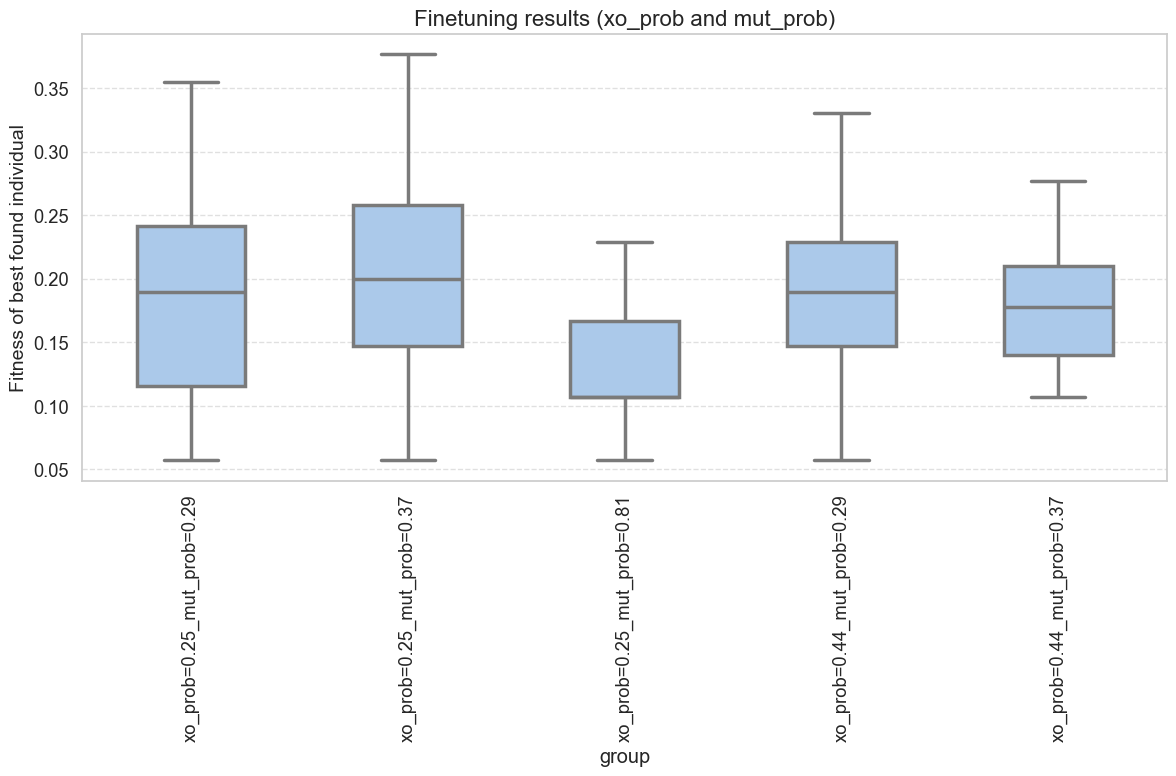

In [ ]:
# Convert the results into a long-format DataFrame for Seaborn
data = []
for config_label, fitness_values in finetune_fitness_results.items():
    for value in fitness_values:
        data.append({
            'value': value,
            'group': config_label
        })

df_long = pd.DataFrame(data)

# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='group', y='value', data=df_long, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Finetuning results (xo_prob and mut_prob)', fontsize=16)
plt.ylabel('Fitness of best found individual', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


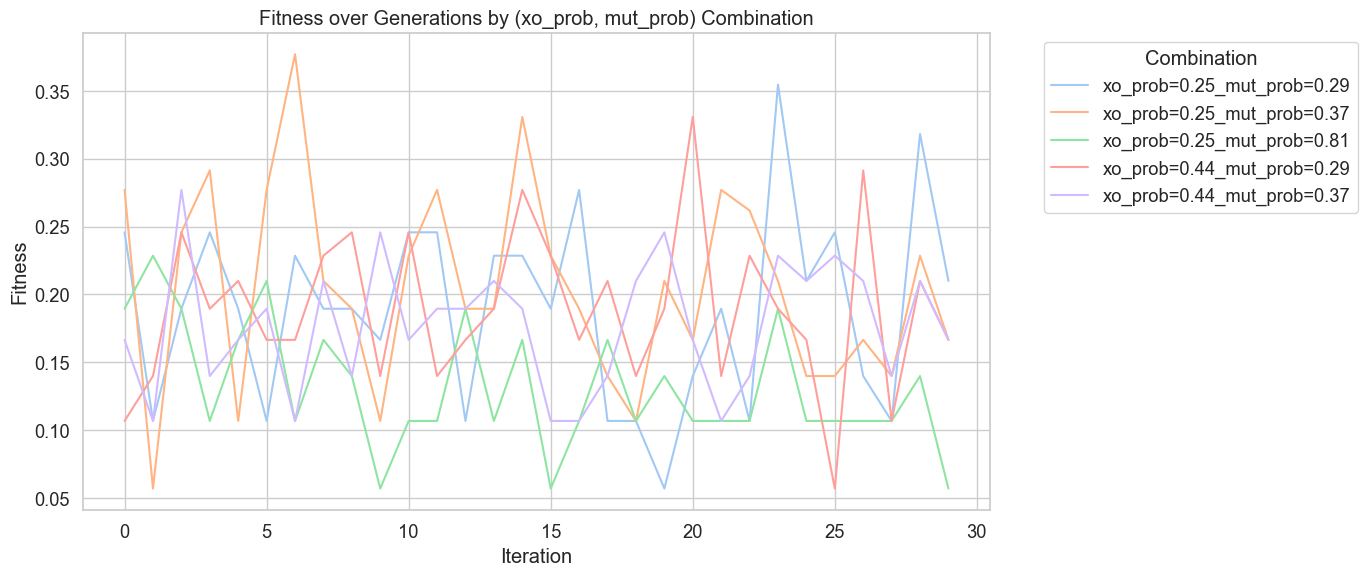

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

# Loop over each configuration and plot its fitness trend
for name, fitness_values in finetune_fitness_results.items():
    ax.plot(range(len(fitness_values)), fitness_values, label=name)

ax.set_title("Fitness over Generations by (xo_prob, mut_prob) Combination")
ax.set_xlabel("Iteration")
ax.set_ylabel("Fitness")
ax.legend(title="Combination", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

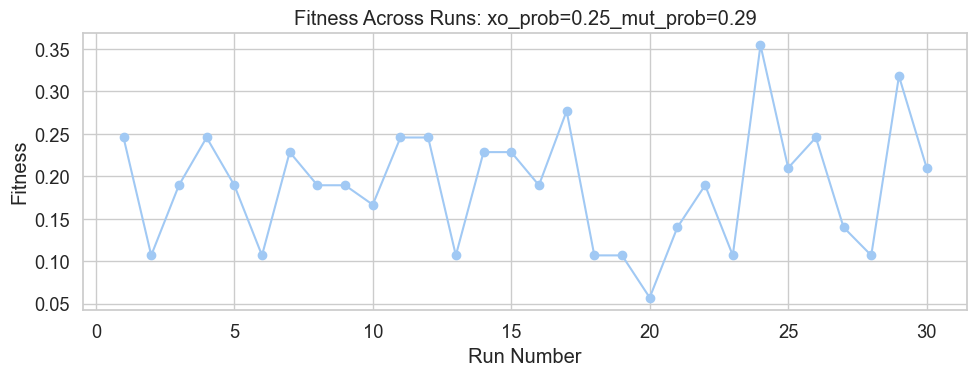

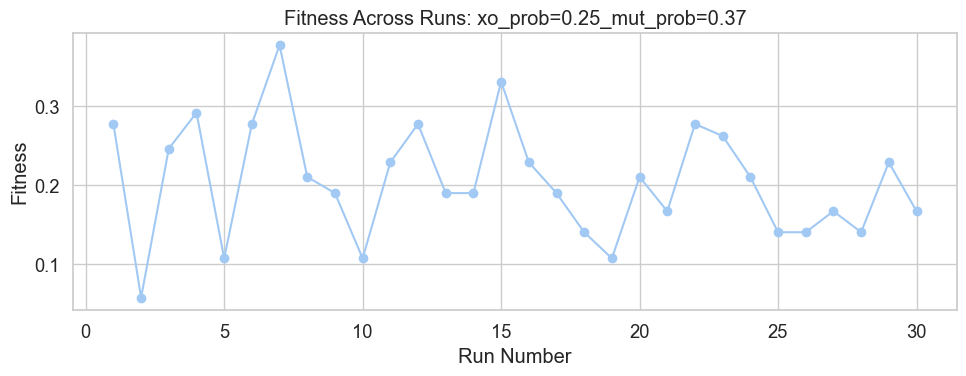

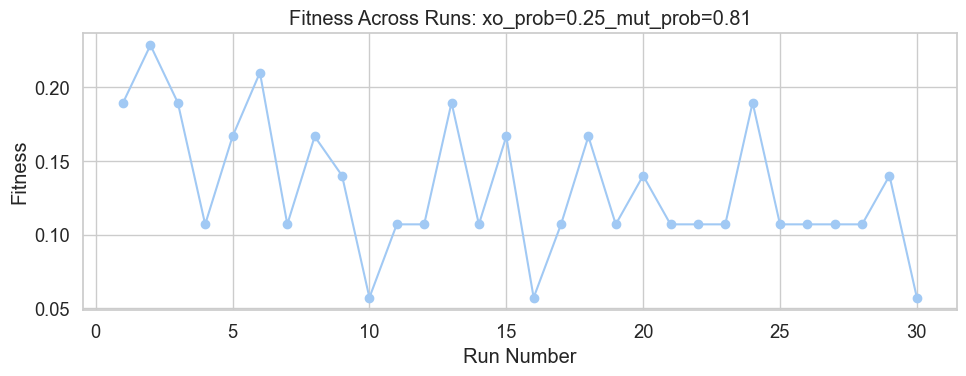

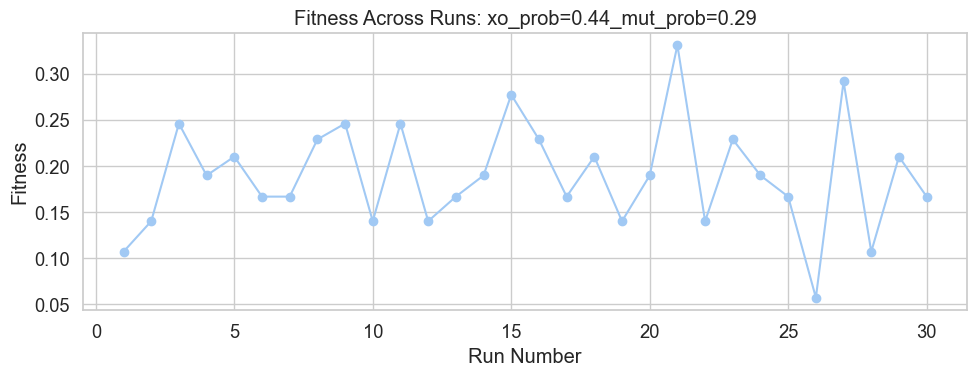

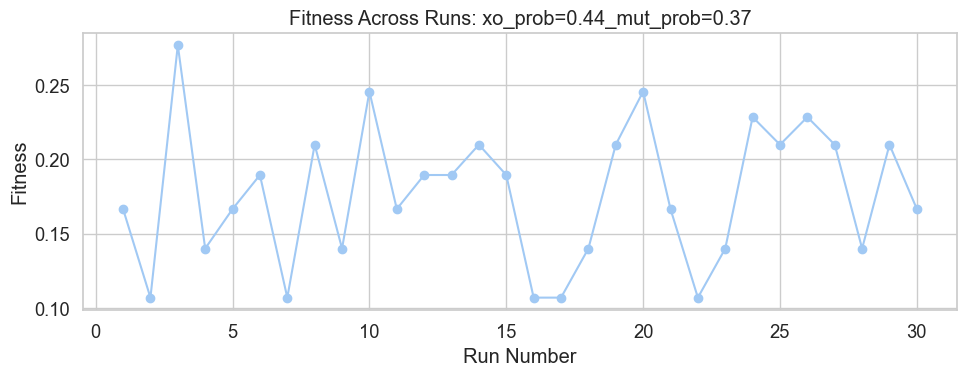

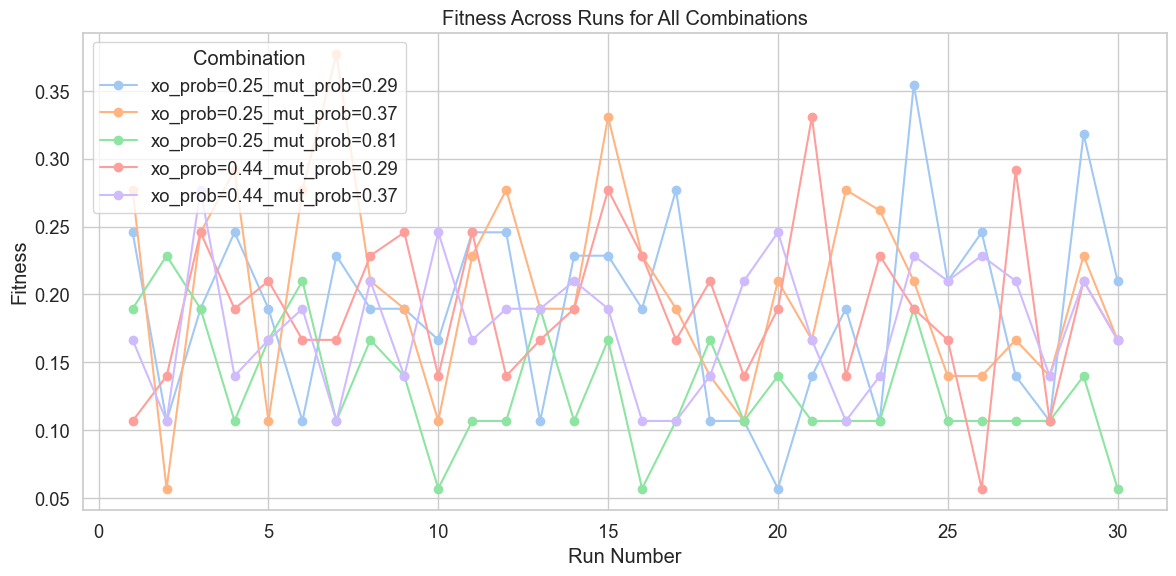

In [ ]:
for i, (name, values) in enumerate(finetune_fitness_results.items()):
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(values) + 1), values, marker='o')
    plt.title(f"Fitness Across Runs: {name}")
    plt.xlabel("Run Number")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(12, 6))
for name, values in finetune_fitness_results.items():
    plt.plot(range(1, len(values) + 1), values, label=name, marker='o')

plt.title("Fitness Across Runs for All Combinations")
plt.xlabel("Run Number")
plt.ylabel("Fitness")
plt.legend(title="Combination")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
groups = list(finetune_fitness_results.values())
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-test: H = {stat:.4f}, p = {p:.4f}")

if p < 0.05:
    print("Significant differences found between at least one pair of combinations.")
else:
    print("No significant differences found.")

Kruskal-Wallis H-test: H = 23.4756, p = 0.0001
Significant differences found between at least one pair of combinations.


In [ ]:

alpha = 0.01  

print(f"Pairwise Mann-Whitney U Tests (α = {alpha}):\n")

for (label1, group1), (label2, group2) in combinations(finetune_fitness_results.items(), 2):
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    decision = "✅ Statistically Significant" if p < alpha else "❌ Not Significant"
    print(f"{label1} vs {label2} → U = {stat:.2f}, p = {p:.4f} → {decision}")

Pairwise Mann-Whitney U Tests (α = 0.01):

xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.25_mut_prob=0.37 → U = 398.00, p = 0.4441 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.25_mut_prob=0.81 → U = 672.00, p = 0.0008 → ✅ Statistically Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.29 → U = 453.50, p = 0.9644 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.37 → U = 497.50, p = 0.4839 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.25_mut_prob=0.81 → U = 722.00, p = 0.0000 → ✅ Statistically Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.44_mut_prob=0.29 → U = 502.50, p = 0.4406 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.44_mut_prob=0.37 → U = 552.00, p = 0.1319 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.81 vs xo_prob=0.44_mut_prob=0.29 → U = 191.00, p = 0.0001 → ✅ Statistically Significant
xo_prob=0.25_mut_prob=0.81 vs xo_prob=0.44_mut_prob=0.37 → U = 220.50, p = 0.0006 → ✅ Statistically Significant

xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.25_mut_prob=0.81 is significant, which means changing the mutation probability from 0.29 to 0.81 leads to significantly different fitness results 

xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.29 is not significant, which means changing crossover probability from 0.25 to 0.44 doesn't lead to signfigicantly different fitness results



In [ ]:
for label, results in finetune_fitness_results.items():
    avg = np.mean(results)
    print(f"{label} → Avg = {avg:.4f}")

xo_prob=0.25_mut_prob=0.29 → Avg = 0.1891
xo_prob=0.25_mut_prob=0.37 → Avg = 0.2042
xo_prob=0.25_mut_prob=0.81 → Avg = 0.1317
xo_prob=0.44_mut_prob=0.29 → Avg = 0.1894
xo_prob=0.44_mut_prob=0.37 → Avg = 0.1770


xo_prob=0.25_mut_prob=0.81 with Avg = 0.1317 has the lower average fitness value

Between the 5 tested combinations, the one with higher mutation probability (around 0.81) performed better, showing a lower average fitness for the 30 iterations run. However, changing in crossover probabilities (from 0.25 to 0.44) did not show a significance chance.

In [ ]:
print("Levene’s Test for Equal Variance (α = 0.01):\n")
for (label1, group1), (label2, group2) in combinations(finetune_fitness_results.items(), 2):
    stat, p = levene(group1, group2)
    significance = "✅ Significant" if p < 0.01 else "❌ Not Significant"
    print(f"{label1} vs {label2} → W = {stat:.2f}, p = {p:.4f} → {significance}")

Levene’s Test for Equal Variance (α = 0.01):

xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.25_mut_prob=0.37 → W = 0.06, p = 0.8064 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.25_mut_prob=0.81 → W = 3.85, p = 0.0547 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.29 → W = 0.91, p = 0.3430 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.37 → W = 3.14, p = 0.0818 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.25_mut_prob=0.81 → W = 4.88, p = 0.0312 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.44_mut_prob=0.29 → W = 1.47, p = 0.2296 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.37 vs xo_prob=0.44_mut_prob=0.37 → W = 4.23, p = 0.0443 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.81 vs xo_prob=0.44_mut_prob=0.29 → W = 1.23, p = 0.2721 → ❌ Not Significant
xo_prob=0.25_mut_prob=0.81 vs xo_prob=0.44_mut_prob=0.37 → W = 0.29, p = 0.5913 → ❌ Not Significant
xo_prob=0.44_mut_prob=0.29 vs xo_prob=0.44_mut_prob=0.

In [ ]:
for label, results in finetune_fitness_results.items():
    std = np.std(results)
    print(f"{label} → Std = {std:.4f}")

xo_prob=0.25_mut_prob=0.29 → Std = 0.0691
xo_prob=0.25_mut_prob=0.37 → Std = 0.0715
xo_prob=0.25_mut_prob=0.81 → Std = 0.0444
xo_prob=0.44_mut_prob=0.29 → Std = 0.0577
xo_prob=0.44_mut_prob=0.37 → Std = 0.0461


The combination with mut_prob=0.81 had the lowest standard deviation of the fitness outcomes for all the 30 runs.
However, it's not more "consistent" or it doesn't have less variability than the others, since we cannot reject the null hypothesis on Levene’s test (the variances are equal).

The combination with xo_prob=0.25 and mut_prob=0.81 achieved statistically the best average fitness (the lower one),but also had the lowest standard deviation. We conclude it's the most effective and reiable, and the best for our genetic algorithm. 